In [1]:
%matplotlib inline

import sys
import os
import pathlib

import numpy as np
from scipy import linalg
import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

sys.path.append(os.fspath(pathlib.Path().resolve().parent / 'src'))
import graphdsp as gsp

In [2]:
N = 1000

M = gsp.GeometricUWG.make_random_pretty.__kwdefaults__['N'] // 5
F = list(range(M))

In [3]:
def maxdet(UF):
    N = len(UF)
    S = []
    ldets = []
    D = np.zeros((N,N))
    for i in range(N):
        maxldet = -float('inf')
        argmax = None
        bestD = D.copy()
        for j in range(N):
            if j in S:
                continue
            Dc = D.copy() # candidate to new D
            Dc[j,j] = 1
            evs, _ = np.linalg.eigh(UF.T @ Dc @ UF)
            evs = np.sort(evs)
            logdet = np.sum(np.log(evs[-i-1:]))
            if logdet > maxldet:
                argmax = j
                maxldet = logdet
                bestD = Dc
        S.append(argmax)
        ldets.append(maxldet)
        D = bestD
    return S, ldets

In [4]:
def maxmu(UF, S):
    N = len(UF)
    D = np.zeros((N,N))
    D[S,S] = 1
    return 2 / np.linalg.norm(UF.T @ D @ UF, ord=2)

In [5]:
def gplot(x, *,
          cmap=mpl.cm.get_cmap('viridis'), title=None, 
          colorbar=True, edge_grayscale=False,
          show_indexes=False):
    points = x.graph.nodes
    W = x.graph.W
    N = len(x)
    fig, ax = plt.subplots()
    for i in range(N):
        for j in range(i+1,N):
            if W[i,j] > 0:
                if edge_grayscale:
                    edge_color = "{}".format(1-W[i,j]/W.max())
                else:
                    edge_color = "k"
                ax.plot(points[[i,j],0], points[[i,j],1], 
                        color=edge_color, zorder=1)
    r = x.max() - x.min()
    if r == 0:
        r = 1
    u = (x - x.min()) / r
    scatter = ax.scatter(points[:,0], points[:,1], 
                         s=100, lw=1, edgecolor='k', c=x.values, 
                         cmap=cmap, zorder=2)
    if show_indexes:
        for i in range(N):
            ax.text(points[i,0]+.015, points[i,1]+.015, '{}'.format(i))
    if colorbar:
        cbar = fig.colorbar(scatter)
    ax.set_aspect('equal')
    if title is not None:
        ax.set_title(title)

In [6]:
mu = []
graphs = []
Ss = []
for _ in tqdm_notebook(range(N), desc="random mu"):
    graphs.append(gsp.GeometricUWG.make_random_pretty())
    _, U = graphs[-1].spectral_decomposition()
    UF = U[:,F]
    S, _ = maxdet(UF)
    Ss.append(S)
    mu.append(maxmu(UF, S[:M]))

HBox(children=(IntProgress(value=0, description='random mu', max=1000), HTML(value='')))

/home/pedro/.local/lib/pyenv/versions/3.6.4/envs/gsp/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
/home/pedro/.local/lib/pyenv/versions/3.6.4/envs/gsp/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in log


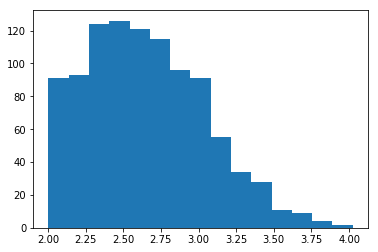

In [7]:
plt.hist(mu, bins=int(np.floor(np.sqrt(N)/2)))
plt.savefig('mu_hist.png', dpi=200)

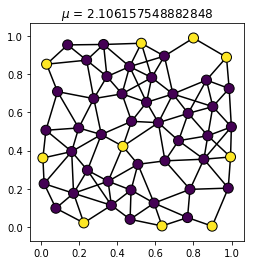

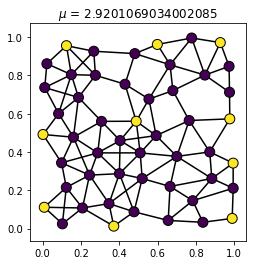

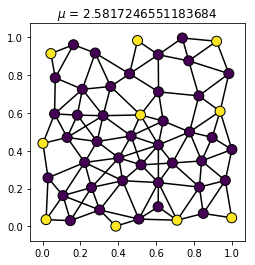

In [8]:
for i in range(3):
    S_mask = np.zeros(len(graphs[i]), dtype=bool)
    S_mask[Ss[i][:M]] = True
    gplot(gsp.GraphSignal(S_mask.astype(float), graph=graphs[i]), colorbar=False)
    plt.gca().set_title(f"$\\mu$ = {mu[i]}")